## Read Data

In [5]:
# Veri okumak icin keras kütüphanesinden generator kullanildi.
from keras.preprocessing.image import ImageDataGenerator
# okunacak fotoğrafların pixellerinin 255'e bölüneceği belirtildi.
datagen = ImageDataGenerator(rescale=1./255)
# Bu sayede bir iterator yardimiyla her seferinde batchsize kadar veri okuyoruz.
# bath_size parametresi belirtilmezse default olarak 32 li alir.
# alinan fotograf boyutlari target_size parametresi sayesinde istenilen boyuta getiriliyor.
train_it = datagen.flow_from_directory('dataset/train/', class_mode='categorical', target_size=(224, 224), shuffle=True)
test_it = datagen.flow_from_directory('dataset/test/', class_mode='categorical', target_size=(224, 224), shuffle=False)
val_it = datagen.flow_from_directory('dataset/valid/', class_mode='categorical', target_size=(224, 224), shuffle=True)

# Iteratorun calistigini gorelim
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Batch shape=(32, 224, 224, 3), min=0.000, max=1.000


## From scratch

In [6]:
# sıfırdan model oluşturma
import keras
from keras.models import Model, Sequential
from keras.layers import Input,Conv2D, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='glorot_normal', input_shape=(224, 224, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.2))
# model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='glorot_normal'))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

#opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
dropout (Dropout)            (None, 220, 220, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 216, 32)      25632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 216, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1492992)           0         
_________________________________________________________________
dense (Dense)                (None, 10)                14929930  
Total params: 14,957,994
Trainable params: 14,957,994
Non-trainable params: 0
____________________________________________

## Transfer Learning

In [9]:
# Öğrenim aktarımı yöntemiyle model oluşturma
import keras
from keras.models import Model, Sequential
from keras.layers import Input,Conv2D, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

# resnet_model = ResNet50(weights='imagenet', include_top=True, input_shape=(224,224,3))
# resnet_model.summary()

vgg_model = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
# resnet icin
# for layer in resnet_model.layers[:-3]:
# 	layer.trainable = False

# class1 = Dense(1024, activation='relu')(resnet_model.layers[-2].output)
# output = Dense(10, activation='softmax')(class1)
# model = Model(inputs=resnet_model.inputs, outputs=output)
# model.summary()
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# vgg icin 
# son 4 katman eğitilmek istenirse for layer in vgg_model.layers[-3]: yapılmalı
for layer in vgg_model.layers:
	layer.trainable = False

class1 = Dense(1024, activation='relu')(vgg_model.layers[-2].output)
output = Dense(10, activation='softmax')(class1)
model = Model(inputs=vgg_model.inputs, outputs=output)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Train and evaluate

In [7]:
checkpointer = ModelCheckpoint(
    filepath='checkpoint_model.hdf5'
    , monitor="val_loss"
    , verbose=1
    , save_best_only=True
    , mode='auto'
)
# gereksiz beklememek için early stopping kullanılabilir, opsiyonel.
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)

In [ ]:
score = model.fit(
        train_it
        , epochs=10
        , validation_data=val_it
        ,callbacks=[checkpointer, early_stop]
        , batch_size=32
    )

In [ ]:
from keras.models import load_model
# eğitimdeki en iyi model tekrar yükleniyor. 
model = load_model('checkpoint_model.hdf5')
#model.summary()

In [ ]:
# istenilirse model daha sonra yüklenmek icin kaydedilebilir.
# model.save('/content/drive/MyDrive/models/resnet_last_layer.hdf5')

In [ ]:
results = model.evaluate(test_it, verbose=1)
print(results)

2813/2813 [==============================] - 97s 34ms/step - loss: 2.0308 - accuracy: 0.2933
[2.030766248703003, 0.29332223534584045]


In [ ]:
# consufion matrix icin tahminler aliniyor
probabilities = model.predict(test_it)
predicted_labels = [x.argmax() for x in probabilities]
y_true = test_it.classes

In [ ]:
import matplotlib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
font = {
'family': 'Times New Roman',
'size': 12
}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_true, predicted_labels)
print(mat)
#plot_confusion_matrix(conf_mat=mat, figsize=(8, 8), show_normed=False)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, class_name in enumerate(class_names):
    print(f'{class_name}. acc: {100*(mat[i][i]/sum(mat[i])):.2f}%')

[[3099  924 1159  115  311   91  473  497 1472  859]
 [ 324 3818  156  267  289   75  767  414  477 2413]
 [ 388  730 1180  881 1056  982 2302  614  568  299]
 [  94  401  489 1290 1197  927 3364  682  278  278]
 [ 319  271  440  843 1374 1402 2657 1291  201  202]
 [ 133  623  613 1118 1265 1005 2706  879  285  373]
 [  37  213  201  857  880  807 5483  287  141   94]
 [ 256  496  220  698 1422  602 1608 3072  156  470]
 [1140  839  863  288  366  179  946  477 2912  990]
 [ 522 2311  135  265  414   90  748  740  609 3166]]
airplane. acc: 34.43%
automobile. acc: 42.42%
bird. acc: 13.11%
cat. acc: 14.33%
deer. acc: 15.27%
dog. acc: 11.17%
frog. acc: 60.92%
horse. acc: 34.13%
ship. acc: 32.36%
truck. acc: 35.18%


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


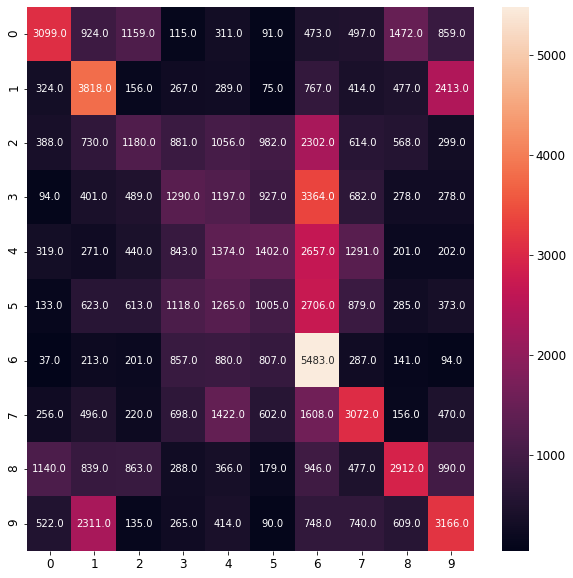

In [ ]:
# confusion matrixi görselleştirmek istenirse kullanılabilir, şart değil.
import seaborn as sn
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
#sn.set(font_scale=1.4) # for label size
a = sn.heatmap(mat, annot=True, annot_kws={"size": 10}, ax=ax, fmt=".1f") # font size
#fig.show()

In [ ]:
# consufion matrix kaydedilmek istenirse kullanılabilir
# fig.savefig('1.png')

## Extract Features

In [8]:
# veri setindeki train, test, validation fotoğrafları tek klasörde toplanıyor. pathler ilgili şekilde düzenlenmeli

import os
import glob
import numpy as np
from shutil import copyfile
symlink = False    # If this is false the files are copied instead
doit = True
if doit:
    cinic_directory = "dataset"
    enlarge_directory = cinic_directory + "/merged"
    classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    sets = ['train', 'valid', 'test']
    if not os.path.exists(enlarge_directory):
        os.makedirs(enlarge_directory)

    for c in classes:
        if not os.path.exists('{}/{}'.format(enlarge_directory, c)):
            os.makedirs('{}/{}'.format(enlarge_directory, c))

    for s in sets:
        for c in classes:
            source_directory = '{}/{}/{}'.format(cinic_directory, s, c)
            filenames = glob.glob('{}/*.png'.format(source_directory))
            for fn in filenames:
                dest_fn = fn.split('/')[-1]
                if s == 'train' or s == 'valid' or 'test':
                    dest_fn = '{}/{}/{}'.format(enlarge_directory, c, dest_fn)
                    if symlink:
                        if not os.path.islink(dest_fn):
                            os.symlink(fn, dest_fn)
                    else:
                        copyfile(fn, dest_fn)

In [11]:
from keras.models import load_model
# daha önceden transfer learning ile eğitilmiş model kaydedildiyse yüklenebilir
# temp_model = load_model('checkpoint_model.hdf5')
temp_model = model

In [12]:
from keras.models import Model
# son katmanı çıkartılarak output olarak 1024 fully connected layerdan çıkan vektör alınıyor.
model = Model(inputs=temp_model.inputs, outputs=temp_model.layers[-2].output)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [13]:
from keras.preprocessing.image import ImageDataGenerator
# birleştirilmiş veri seti tekrar okunuyor.
# batch_size memory kapasitesine göre değişkenlik gösterebilir.
datagen = ImageDataGenerator(rescale=1./255)
all_it = datagen.flow_from_directory('dataset/merged/', batch_size=270, class_mode='categorical', target_size=(224, 224), shuffle=False)

Found 270000 images belonging to 10 classes.


In [ ]:
from tqdm import tqdm
import pickle
import gc
# hangi model için datasetin featureları çıkarılacaksa o şekilde isimlendirilmeli 
filename="features_vgg_last_layer.pkl"
# toplamda 270.000 image var. Buna göre batch_size * range 270.000 yapmalı. For döngüsü datagen'in batch_size'ına göre düzenlenebilir.
for i in tqdm(range(1000), desc ="Extracting image features"):
    x = all_it.next()[0]
    prediction = model.predict(x)
    # predictleri dosyaya yazıyoruz.
    with open(filename, 'ab+') as fp:
        pickle.dump(prediction,fp)
    # daha az memory kullanımı için gerekli
    del prediction
    del x
    gc.collect()

## Calculate distances

In [2]:
import os
import numpy as np

all_images = []
# buraya birleştirilmiş dataset pathi verilmeli
folder_list = os.listdir('dataset/merged')
folder_list = sorted(folder_list)

for folder in folder_list:
    print(folder)
    images = os.listdir('dataset/merged/'+ folder)
    images = sorted(images)
    for image in images:
        all_images.append(os.path.abspath('dataset/merged/'+ folder + '/' + image))
    
# fotoğraf listesi alındı
all_images = np.array(all_images)
all_images.shape

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


(270000,)

In [ ]:
import random
# 10 sınıf icin her sınıfa ait 3 test örneği seçildi
test_samples = []
for i in range(0, 10):
    k = i * 27000
    random_numbers = random.sample(range(k, k+27000), 3)
    test_samples.append(random_numbers)

In [ ]:
import pickle
objects = []
# kaydedilmiş feature pathi verilmesi gerekli. Feature lar alınacak.
with (open("features_vgg_last_layer.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [ ]:
import numpy as np
# 270.000 adet fotografa ait 1024 lü  feature vektörleri alindi
features = np.array(objects).reshape(270000, 1024)

[9.489745, 2.0659597, 0.944494, 6.556442, 9.765502, 1.9272512, 2.4965334, 1.1489232, 5.412102, 11.274342, 0.85407424, 2.9236186, 0.68576264, 5.527953, 2.1906433, 11.285398, 5.937449, 18.215176, 4.5448127, 5.3993044, 0.6613569, 2.0660698, 0.72760606, 8.873293, 6.588839, 3.8212252]


In [ ]:
# cosinus benzerligi hesaplayan fonksiyon
def cos_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

# en yakin 5 liyi bulan fonksiyon
def find_top_5(index, features):
    distances = np.array([cos_sim(x, features[index]) for x in features])
    max_6 = distances.argsort()[-6:]
    max_5 = np.delete(max_6, np.where(max_6 == index))
    return max_5

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# en yakin 5 liyi gösteren fonksiyon
def plot_best_5(test_index, max_5):
    classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    gs = gridspec.GridSpec(2, 5)
    gs.update(wspace=0.5)
    ax1 = plt.subplot(gs[0, 2], )
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[1, 2])
    ax5 = plt.subplot(gs[1, 3])
    ax6 = plt.subplot(gs[1, 4])

    ax1.title.set_text('Test Image - ' + classes[int(test_index/27000)])
    ax2.title.set_text(classes[int(max_5[4]/27000)])
    ax3.title.set_text(classes[int(max_5[3]/27000)])
    ax4.title.set_text(classes[int(max_5[2]/27000)])
    ax5.title.set_text(classes[int(max_5[1]/27000)])
    ax6.title.set_text(classes[int(max_5[0]/27000)])

    ax1.imshow(mpimg.imread(all_images[test_index]))
    ax2.imshow(mpimg.imread(all_images[max_5[4]]))
    ax3.imshow(mpimg.imread(all_images[max_5[3]]))
    ax4.imshow(mpimg.imread(all_images[max_5[2]]))
    ax5.imshow(mpimg.imread(all_images[max_5[1]]))
    ax6.imshow(mpimg.imread(all_images[max_5[0]]))

    plt.show()

# plot_best_5(0, max_5)

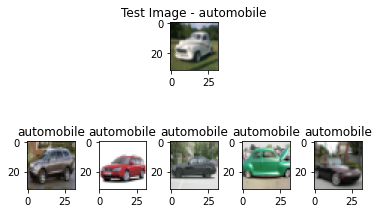

In [ ]:
# Tekli örnek
plot_best_5(27000, find_top_5(27000, features))

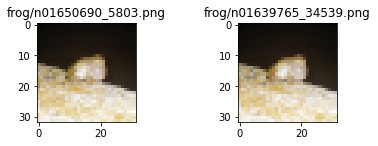

In [ ]:
# verisetinde farkli id li 2 farkli fotograflar tespit edildi. Raporda detaylı anlatıldı. Örnek:

aa = gridspec.GridSpec(2, 2)
aa.update(wspace=0.5)
axs1 = plt.subplot(aa[0, 0])
axs2 = plt.subplot(aa[0, 1])
axs1.title.set_text('frog/n01650690_5803.png')
axs2.title.set_text('frog/n01639765_34539.png')
axs1.imshow(mpimg.imread(all_images[185561]))
axs2.imshow(mpimg.imread(all_images[168301]))
plt.show()

airplane samples
Test 1:


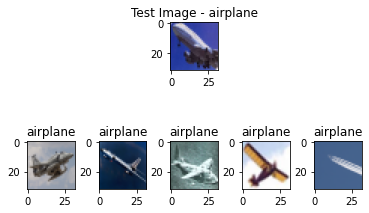

---------------------------------------
Test 2:


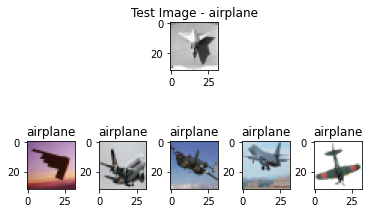

---------------------------------------
Test 3:


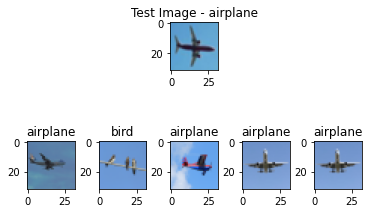

---------------------------------------
automobile samples
Test 4:


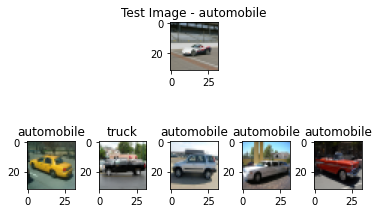

---------------------------------------
Test 5:


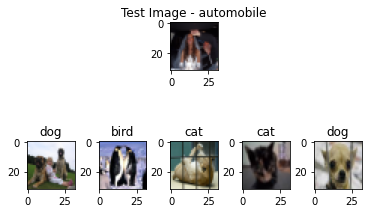

---------------------------------------
Test 6:


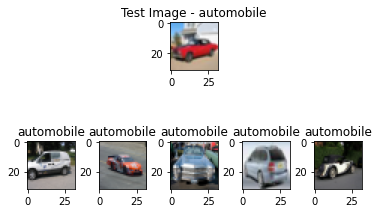

---------------------------------------
bird samples
Test 7:


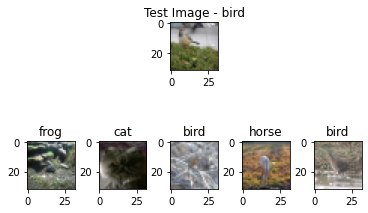

---------------------------------------
Test 8:


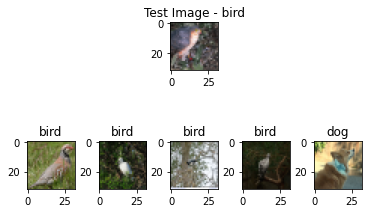

---------------------------------------
Test 9:


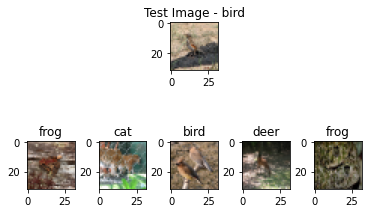

---------------------------------------
cat samples
Test 10:


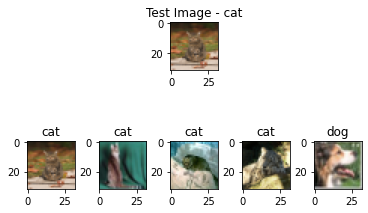

---------------------------------------
Test 11:


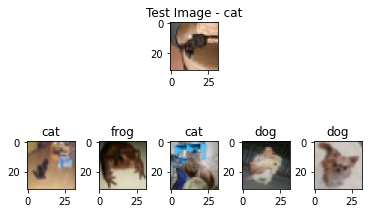

---------------------------------------
Test 12:


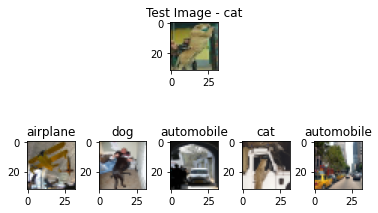

---------------------------------------
deer samples
Test 13:


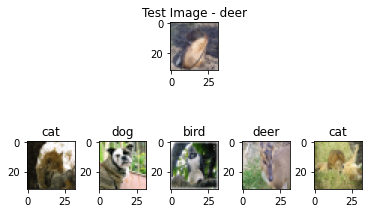

---------------------------------------
Test 14:


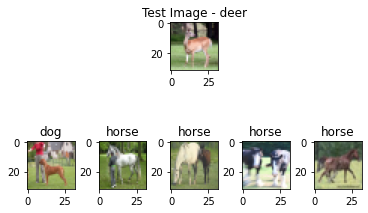

---------------------------------------
Test 15:


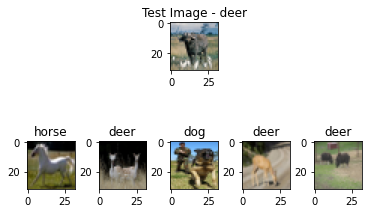

---------------------------------------
dog samples
Test 16:


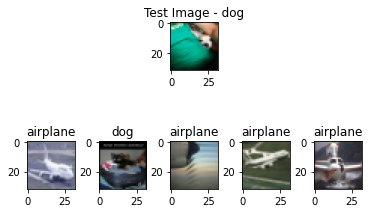

---------------------------------------
Test 17:


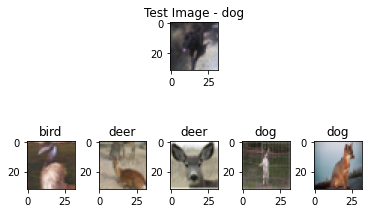

---------------------------------------
Test 18:


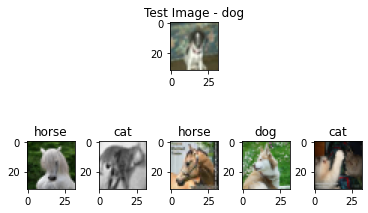

---------------------------------------
frog samples
Test 19:


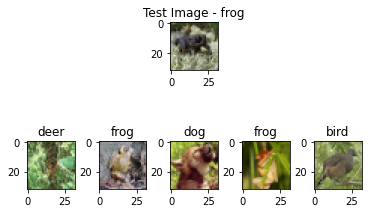

---------------------------------------
Test 20:


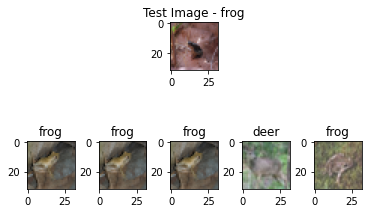

---------------------------------------
Test 21:


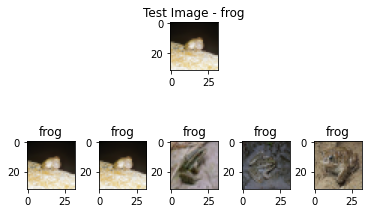

---------------------------------------
horse samples
Test 22:


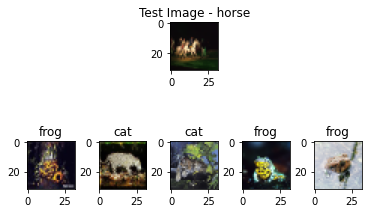

---------------------------------------
Test 23:


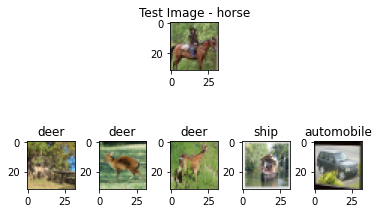

---------------------------------------
Test 24:


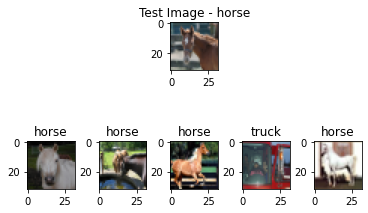

---------------------------------------
ship samples
Test 25:


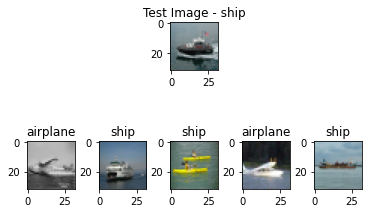

---------------------------------------
Test 26:


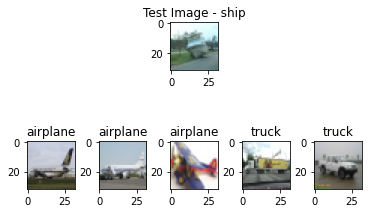

---------------------------------------
Test 27:


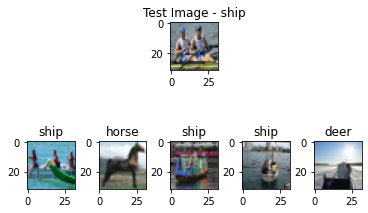

---------------------------------------
truck samples
Test 28:


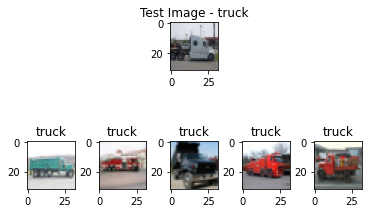

---------------------------------------
Test 29:


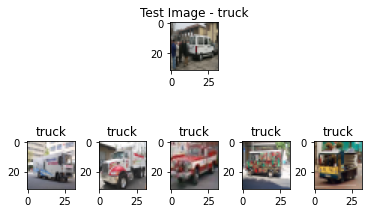

---------------------------------------
Test 30:


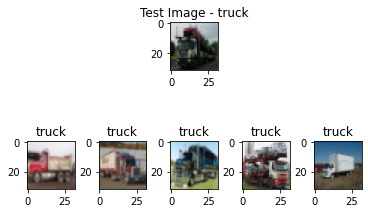

---------------------------------------


In [ ]:
# test fotograflari ile en çok benzerliğe sahip 5'er fotograf gösterildi.
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
k = 1
for index, class_samples in enumerate(test_samples):
    print(f'{classes[index]} samples')
    for i in class_samples:
        print(f'Test {k}:')
        k +=1
        plot_best_5(i, find_top_5(i, features))
        print('---------------------------------------')
